In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
os.chdir(r"C:\Users\Aman Khatri\Desktop\Work\AAM\Backlash Info")

In [190]:
#Load saved dataset
dataindexer=0
testit = os.getcwd()+r"\aam lash2\test data\1581100129.txt"
####### Main calculation and plotting loop, iterating with new data as selected #####

In [191]:
LASH = pd.read_csv(str(testit), header=3)
LASH.columns = ['CWG', 'PIN', 'CCWG', 'CCWP']

In [192]:
Enc = pd.read_csv(str(testit), header=None,skiprows=1,nrows=3)

In [193]:
#####Reading variables directly from top 3 rows of text file######
encdt=float(Enc.iloc[2,0]) #time increment of data in seconds
tpin=float(Enc.iloc[1,0]) #Pinion Teeth
tgear=float(Enc.iloc[1,1]) #Gear Teeth
lgain =float(Enc.iloc[0,2]) #diameter gain for lash calcs
offset=float(Enc.iloc[0,3]) #calculation offset
Lmin=float(Enc.iloc[2,2]) #Minimum Backlash limit MM
Lmax=float(Enc.iloc[2,3]) #Maximum Backlash limit MM
Atype=Enc.iloc[0,1] #Axle Type
sernum=Enc.iloc[0,0] #Part ID
rdia=float(Enc.iloc[2,1]) #raw diameter from file---gear dia
gencts=float(Enc.at[1,2]) #gear encoder counts per rev
pencts=float(Enc.at[1,3]) #pinion encoder cts per rev

dia= rdia*lgain #calculating diameter
ratio= tgear/tpin #Gear Pinion Ratio (IDEAL)

#####Calculating variables from the remaining Data rows of text file#######
gstart=LASH.loc[0,'CWG']   #CW Gear start Degree
gend=LASH.loc[LASH.index[-1],'CWG'] #CW Gear End Degree
pref=LASH.loc[0,'PIN']  #CW Pininon start Degree
plast=LASH.loc[LASH.index[-1],'PIN'] #CW Pinion end Degree

gref2=LASH.loc[0,'CCWG'] #CCW Gear start Degree
glast2=LASH.loc[LASH.index[-1],'CCWG'] #CCW Gear end Degree
pref2=LASH.loc[0,'CCWP'] #CCW Pinion start Degree
plast2=LASH.loc[LASH.index[-1],'CCWP'] #CCW Pinion end Degree
ratioCW=(plast-pref)/(gend-gstart) #CW Gear Pinion Ratio(Calculated)
ratioCCW=(plast2-pref2)/(glast2-gref2) #CCW Gear Pinion Ratio(Calculated)

glast2C=glast2+(plast-plast2)/ratio      ##### Some new measure of CCW gear end degree...adding the diff b/w last degree of CW & CCW of pinion
CWteend=gend-gstart-(plast-pref)/ratio   #Actual Gear rotation range minus Gear rotation range calculated from pinion rotation
LASH['DEG']=(LASH['CWG']-gstart)     #shifting the gear rotation starting point to zero
LASH['RAD']=(LASH['DEG']*np.pi/180)  #converting degrees to radian
#### Gear TE in Counts Clockwise & Counterclockwise ######## 
LASH['TECW']=(LASH['DEG']-((LASH['PIN']-pref)/(ratio)))   #Transmission Error i.e. Gear rotation diff w.r.t gear rotation calculated from pinion
LASH['CW TE microrad']=(LASH['TECW']*np.pi*1000000/180)   #Convert to microradian
LASH['TECCW']=(LASH['CCWG']-(glast2C-(plast-LASH['CCWP'])/(tgear/tpin))+(glast2C-gend)+CWteend)
LASH['CCW TE microrad']=(LASH['TECCW']*np.pi*1000000/180) #Convert to microradian
### "Raw" Backlash Calculations without gain and offset ##########
LASH['PINCOMP']=(LASH['PIN']-LASH['CCWP'])       #Diff in Degree of Forward and backward movement of pinion
LASH['GEARCOMP']=(LASH['PINCOMP']/(tgear/tpin))  #expected diff in Degree of Forward and Backward of gear
LASH['COMPGRCCW']=(LASH['GEARCOMP']+LASH['CCWG']) #
LASH['RAW Backlash MM']=((LASH['COMPGRCCW']-LASH['CWG'])/360*np.pi*rdia)  #Backlash is expected - actual diff in degree if forward and backard motion of gear 
### Backlash calculations including gain and offset in values #########
LASH['Backlash MM']=((LASH['COMPGRCCW']-LASH['CWG'])/360*np.pi*dia+offset) #Balancing for backlash offset and calculating backlash using corrected diameter using dia gain for lash cacl
##### Pinion velocity calculations based on time increment of data acquisition #######
LASH['PCWrpm'] = (LASH['PIN'] - LASH['PIN'].shift(1))/360/encdt*60
LASH['PCCWrpm'] = (LASH['CCWP'] - LASH['CCWP'].shift(1))/360/encdt*60
LASH.loc[LASH['PCCWrpm']>150,'PCCWrpm']= 0.0
LASH.loc[LASH['PCCWrpm']<10,'PCCWrpm']= 'NaN'



avglash=LASH['Backlash MM'].mean()
maxlash=round(LASH['Backlash MM'].max(), 3)
minlash=round(LASH['Backlash MM'].min(), 3)
ravglash=LASH['RAW Backlash MM'].mean()


In [194]:
LASH

,CWG,PIN,CCWG,CCWP,DEG,RAD,TECW,CW TE microrad,TECCW,CCW TE microrad,PINCOMP,GEARCOMP,COMPGRCCW,RAW Backlash MM,Backlash MM,PCWrpm,PCCWrpm
0,112.078420,459.639706,112.338002,459.615710,0.000000,0.000000,0.000000,0.000000,0.265435,4632.712813,0.023996,0.005853,112.343855,0.243217,0.221057,NaN,NaN
1,112.169871,460.014040,112.427208,459.981546,0.091451,0.001596,0.000150,2.615614,0.265412,4632.306349,0.032493,0.007925,112.435133,0.243059,0.220906,124.777954,121.945
2,112.261332,460.388417,112.516401,460.347354,0.182912,0.003192,0.000299,5.222030,0.265384,4631.822304,0.041063,0.010015,112.526417,0.242897,0.220752,124.792521,121.936
3,112.352800,460.762825,112.605586,460.713141,0.274380,0.004789,0.000449,7.830577,0.265352,4631.271588,0.049683,0.012118,112.617704,0.242731,0.220594,124.802531,121.929
4,112.444274,461.137273,112.694764,461.078910,0.365854,0.006385,0.000594,10.366166,0.265318,4630.674156,0.058363,0.014235,112.708998,0.242566,0.220438,124.815918,121.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,471.665003,1933.801390,471.893951,1933.735769,359.586583,6.275970,0.034953,610.039372,0.279906,4885.278800,0.065621,0.016005,471.909956,0.224450,0.203228,122.565389,124.938
3996,471.754803,1934.169093,471.985457,1934.110539,359.676383,6.277537,0.035069,612.070754,0.280005,4887.006555,0.058554,0.014281,471.999739,0.224434,0.203212,122.567668,124.923
3997,471.844614,1934.536796,472.076946,1934.485265,359.766194,6.279105,0.035196,614.292272,0.280097,4888.607154,0.051531,0.012569,472.089514,0.224402,0.203181,122.567627,124.909
3998,471.934434,1934.904505,472.168413,1934.859934,359.856014,6.280672,0.035331,616.639699,0.280181,4890.085117,0.044571,0.010871,472.179284,0.224356,0.203138,122.569946,124.89


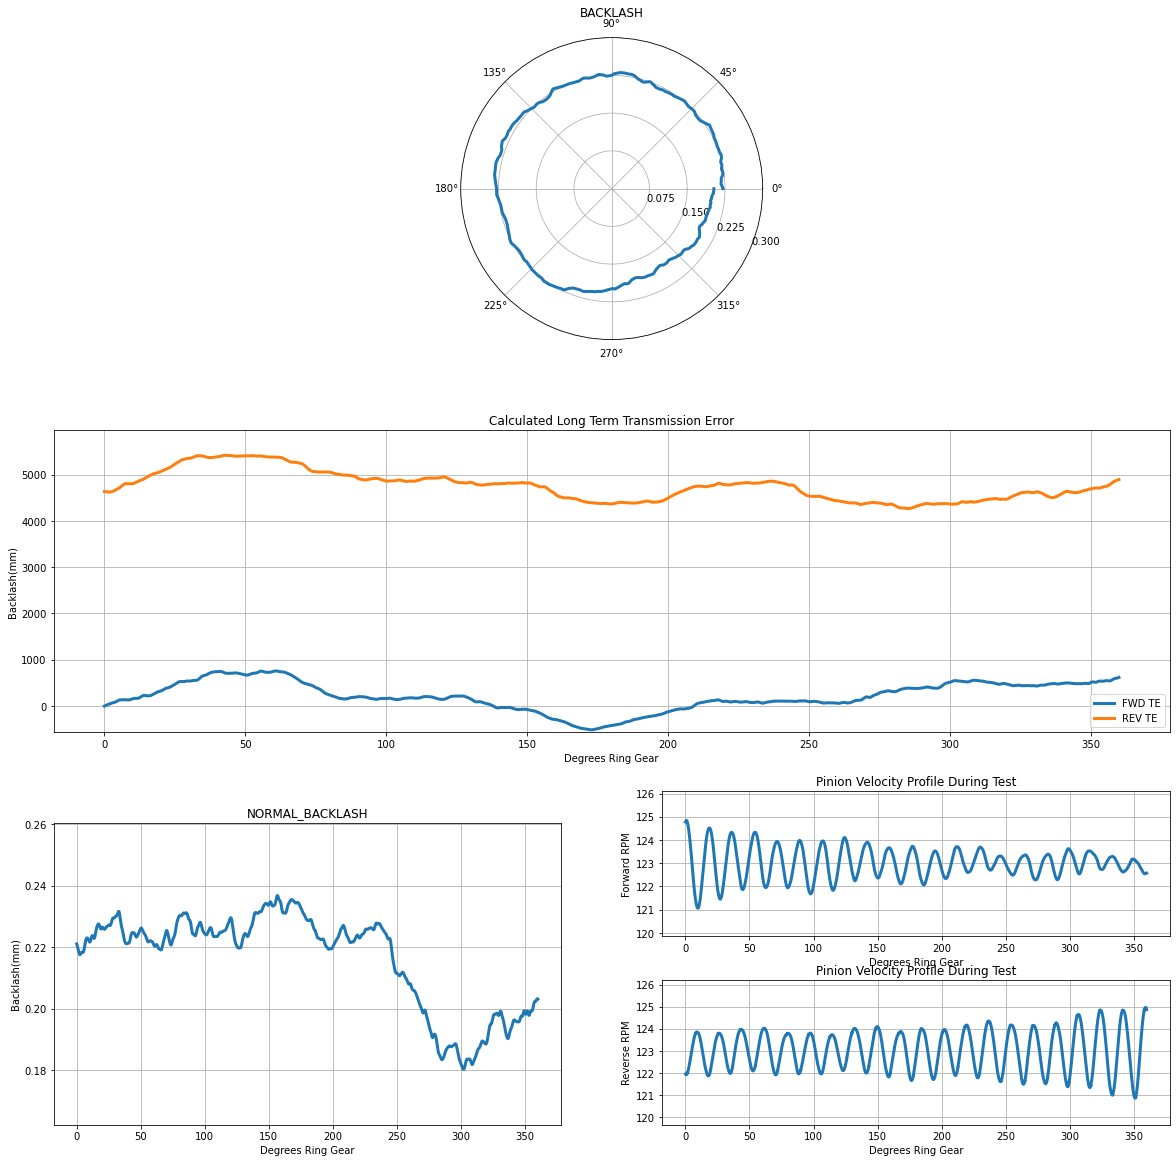

In [199]:
fig = plt.figure(figsize = [20,20])


ax1 = fig.add_subplot(3,3,2, projection = 'polar')
ax1.plot(LASH['RAD'],LASH['Backlash MM'], label='Backlash', linewidth=3)
ax1.set_rticks([0.075, 0.150, 0.225, 0.3])  # less radial ticks
ax1.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax1.grid(True)
plt.title("BACKLASH")


ax2 = fig.add_subplot(3,1,2)
ax2.plot(LASH['DEG'],LASH['CW TE microrad'], label='FWD TE', linewidth=3)
ax2.plot(LASH['DEG'],LASH['CCW TE microrad'], label='REV TE', linewidth=3)
plt.ylim(np.min([LASH['CW TE microrad'].min(), LASH['CCW TE microrad'].min()])*1.1,np.max([LASH['CW TE microrad'].max(), LASH['CCW TE microrad'].max()])*1.1)
plt.grid()
plt.ylabel("Backlash(mm)")
plt.xlabel("Degrees Ring Gear")
plt.title("Calculated Long Term Transmission Error")
plt.legend(loc = 'lower right')

ax2 = fig.add_subplot(3,2,5)
ax2.plot(LASH['DEG'],LASH['Backlash MM'], label='Backlash', linewidth=3)
plt.ylim(LASH['Backlash MM'].min()*0.9,LASH['Backlash MM'].max()*1.1)
plt.grid()
plt.ylabel("Backlash(mm)")
plt.xlabel("Degrees Ring Gear")
plt.title("NORMAL_BACKLASH")


ax2 = fig.add_subplot(6,2,10)
ax2.plot(LASH['DEG'],LASH['PCWrpm'], label='Forward RPM', linewidth=3)
plt.ylim(LASH['PCWrpm'].min()*0.99,LASH['PCWrpm'].max()*1.01)
plt.grid()
plt.ylabel("Forward RPM")
plt.xlabel("Degrees Ring Gear")
plt.title("Pinion Velocity Profile During Test")


ax2 = fig.add_subplot(6,2,12)
ax2.plot(LASH['DEG'],LASH['PCCWrpm'], label='Reverse RPM', linewidth=3)
plt.ylim(LASH['PCCWrpm'].astype(float).min()*0.99,LASH['PCCWrpm'].astype(float).max()*1.01)
plt.grid()
plt.ylabel("Reverse RPM")
plt.xlabel("Degrees Ring Gear")
plt.title("Pinion Velocity Profile During Test")

plt.subplots_adjust(hspace = 0.3)

In [200]:
{'Axle Type':Atype,
'Axle Ratio':ratio,
'Gear Calculating Dia':rdia,
'Backlash Gain':lgain,
'Backlash Offset':offset,
'Gear Encoder':gencts,
'Pinion Encoder':pencts
}

{'Axle Type': '10.5 Line Phase II',
 'Axle Ratio': 4.1,
 'Gear Calculating Dia': 105.0,
 'Backlash Gain': 0.95,
 'Backlash Offset': -0.01,
 'Gear Encoder': 36000.0,
 'Pinion Encoder': 36000.0}

In [201]:
{
'Serial No':sernum,
'Reported Avg Backlash':avglash,
'Maximum Backlash':maxlash,
'Mininum Backlash':minlash,
'Measured Forward Ratio':ratioCW,
'Measured Reverse Ratio':ratioCCW,

}

{'Serial No': 1581100129.0,
 'Reported Avg Backlash': 0.2161654510244287,
 'Maximum Backlash': 0.237,
 'Mininum Backlash': 0.18,
 'Measured Forward Ratio': 4.099595972610532,
 'Measured Reverse Ratio': 4.09983115862137}

In [202]:
{
'Part ID':sernum,
'Reported Avg Lash':avglash,
'Calculated Backlash':ravglash,
'Forward Ratio':ratioCW,
'Reverse Ratio':ratioCCW
}   

{'Part ID': 1581100129.0,
 'Reported Avg Lash': 0.2161654510244287,
 'Calculated Backlash': 0.23806889581518842,
 'Forward Ratio': 4.099595972610532,
 'Reverse Ratio': 4.09983115862137}